# Задача
По базе машин с ЮЛЫ данным обучите модель для предсказания цен на машины.

1. Создайте обучающую, тестовую и проверочную выборки. 

2. Оцените качество работы созданной сети, определив средний процент ошибки на проверочной выборке. (Для этого потребуется привести предсказанные моделью значения к первоначальному диапазону цен.)  

3. Подсчитайте ошибку на каждом примере тестовой выборки и суммарный процент ошибки.


Рекомендации:
- в качестве ошибки рекомендуется использовать среднеквадратическую ошибку (mse).
- метрику для данной задачи можно не использовать.
- последний слой модели должен иметь 1 нейрон.
- суммарный процент ошибки = средний модуль ошибки (MAE) / среднюю цену машины. Например, если средняя цена машины 560.000 р, а средняя ошибка 56.000р, то процент ошибки равен 10%.


# Решение

## Импорты

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import utils, Input
from tensorflow.keras.layers import Dense, Conv1D, Flatten, BatchNormalization, Dropout, SpatialDropout1D, MaxPooling1D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau,  EarlyStopping, ModelCheckpoint 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

%matplotlib inline

In [ ]:
# Загрузка датафрейма из google облака
import gdown

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l10/cars_new.csv', None, quiet=True)

'cars_new.csv'

In [ ]:
df_main = pd.read_csv('/content/cars_new.csv', index_col=None)
df_main.head()

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
0,kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0
1,daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0
2,suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0
3,bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0
4,chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0


In [ ]:
df_main.tail()

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
70114,skoda,fabia 5j [рестайлинг],310000,2011,165000,хетчбэк,механика,бензин,1.2,70.0
70115,ford,focus 3 поколение,400000,2011,125000,хетчбэк,механика,бензин,1.6,105.0
70116,mazda,cx-5 1 поколение,1140000,2013,89981,кроссовер,автомат,бензин,2.0,150.0
70117,toyota,bb 2 поколение,550550,2006,183000,минивэн,автомат,бензин,1.3,92.0
70118,chevrolet,trailblazer 1 поколение,430000,2004,205000,внедорожник,автомат,бензин,4.2,275.0


In [ ]:
df_main.shape

(70119, 10)

In [ ]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70119 entries, 0 to 70118
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mark     70119 non-null  object 
 1   model    70119 non-null  object 
 2   price    70119 non-null  int64  
 3   year     70119 non-null  int64  
 4   mileage  70119 non-null  int64  
 5   body     70116 non-null  object 
 6   kpp      70115 non-null  object 
 7   fuel     70119 non-null  object 
 8   volume   70119 non-null  float64
 9   power    70119 non-null  float64
dtypes: float64(2), int64(3), object(5)
memory usage: 5.3+ MB


Видим пустые значения в столбцах body и kpp

## Заполнение нулевых элементов в датасете

In [ ]:
df_main.isna().sum()

mark       0
model      0
price      0
year       0
mileage    0
body       3
kpp        4
fuel       0
volume     0
power      0
dtype: int64

Копия датасета

In [ ]:
df = df_main.copy()

Ищем строки с хотя бы одним пустым элементом

In [ ]:
rows_with_nan = df.isna().any(axis=1)
rows_with_nan = df[rows_with_nan]
rows_with_nan.head(7)

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
768,skoda,yeti 1 поколение,675000,2012,96472,кроссовер,NaN,бензин,1.2,105.0
12236,volkswagen,golf,325000,2005,140000,NaN,автомат,бензин,1.6,102.0
33857,ford,focus 3 поколение,529000,2012,59000,универсал,NaN,бензин,1.6,105.0
46153,volkswagen,passat b6,499000,2006,156000,седан,NaN,бензин,2.0,140.0
55033,ford,fiesta 6 поколение [рестайлинг],589000,2016,57000,седан,NaN,бензин,1.6,105.0
60368,mitsubishi,lancer,268000,2005,121000,NaN,механика,бензин,1.6,98.0
68439,audi,a5 8t [рестайлинг],949900,2013,119000,NaN,автомат,бензин,2.0,211.0


Хотя была возможность заменить NaN на собственные значения, было принято решение удалить 7 строк, тк собственные значения скорее всего смогут повлиять на цф

In [ ]:
df.dropna(axis=0, how='any', inplace=True)
df = df.reset_index(drop=True)

In [ ]:
print(df.shape)
print(df.isna().sum().sum())

(70112, 10)
0


## Функции парсинга и перевода в ohe всех данных кроме model

In [ ]:
COL_MARK     = df.columns.get_loc('mark')
COL_MODEL    = df.columns.get_loc('model')
COL_PRICE    = df.columns.get_loc('price')
COL_YEAR     = df.columns.get_loc('year')
COL_MILEAGE  = df.columns.get_loc('mileage')
COL_BODY     = df.columns.get_loc('body')
COL_KPP      = df.columns.get_loc('kpp')
COL_FUEL     = df.columns.get_loc('fuel')
COL_VOLUME   = df.columns.get_loc('volume')
COL_POWER    = df.columns.get_loc('power')

In [ ]:
# def create_unique_dict(df_name):
#     unique = df[f'{df_name}'].unique()
#     df_dct = [df[f'{df_name}'].nunique() + 1, {unique[i]: i+1 for i in range(len(unique))}]
#     print(df_dct)

# for i in ['mark', 'body', 'kpp', 'fuel']:
#     create_unique_dict(i)

In [ ]:
mark_class = [0, {'kia': 1, 'daewoo': 2, 'suzuki': 3, 'bmw': 4, 'chevrolet': 5, 'hyundai': 6, 'toyota': 7, 'mercedes-benz': 8, 'chery': 9, 'ford': 10, 'mazda': 11, 'peugeot': 12, 'volkswagen': 13, 'audi': 14, 'mitsubishi': 15, 'opel': 16, 'nissan': 17, 'skoda': 18, 'subaru': 19, 'honda': 20, 'renault': 21}]
body_class = [0, {'седан': 1, 'внедорожник': 2, 'кроссовер': 3, 'хетчбэк': 4, 'универсал': 5, 'минивэн': 6, 'лифтбэк': 7, 'купе': 8, 'микроавтобус': 9, 'пикап': 10, 'кабриолет': 11, 'хардтоп': 12, 'родстер': 13, 'тарга': 14, 'лимузин': 15, 'фастбэк': 16}]
kpp_class = [0, {'автомат': 1, 'механика': 2, 'робот': 3, 'вариатор': 4}]
fuel_class = [0, {'бензин': 1, 'дизель': 2, 'гибрид': 3, 'электро': 4, 'газ': 5}]

# Список порогов года выпуска
year_class = [0, [1950, 1960, 1970, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020]]
mileage_class = [0, [50, 300, 1000, 5000, 20000, 40000, 80000, 100000, 130000, 150000, 170000, 200000, 250000, 300000, 400000, 500000, 1000000]]
volume_class = [0, [0.3, 0.5, 0.8, 1, 1.3, 1.5, 2, 2.5, 2.8, 3, 3.5, 4, 4.3, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 10]]
power_class = [0, [float(i) for i in range(11, 1402, 20)]]

In [ ]:
# Вычисление счетчиков для данных разбиения

for class_desc in [mark_class,
                   body_class,
                   kpp_class,
                   fuel_class,
                   year_class,
                   mileage_class,
                   volume_class,
                   power_class]:
    if isinstance(class_desc[1], list):
        class_desc[0] = len(class_desc[1]) + 1
    else:
        class_desc[0] = max(class_desc[1].values()) + 1

In [ ]:
# Стоимость машины делим на 1000 и возвращаем.

def extract_price(arg):
    try:
        price = float(arg)

    except TypeError:
        price = 0.

    return price / 1000.                  # В тысячах рублей

In [ ]:
# Общая функция преобразования строки к multi-вектору
# На входе данные и словарь сопоставления подстрок классам

def str_to_multi(arg, class_dict):
    # Определение размерности выходного вектора
    num_classes = class_dict[0]

    # Создание нулевого вектора
    result = np.zeros(num_classes)
    
    # Поиск значения в словаре и, если найдено,
    # выставление 1. на нужной позиции
    for value, cls in class_dict[1].items():
        if value in arg:
            result[cls] = 1.

    return result

In [ ]:
# Получение one hot encoding представления значения класса
 
def int_to_ohe(arg, class_list):

    # Определение размерности выходного вектора
    num_classes = class_list[0]

    # Поиск верного интервала для входного значения
    for i in range(num_classes - 1):
        if arg < class_list[1][i]:
            cls = i                       # Интервал найден - назначение класса
            break
    else:                                 # Внимание: for/else
        cls = num_classes - 1             # Интервал не найден - последний класс

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(cls, num_classes)

In [ ]:
def extract_row_data(row):
  
    # Извлечение и преобразование данных
    mark = str_to_multi(row[COL_MARK], mark_class)
    body = str_to_multi(row[COL_BODY], body_class)
    kpp = str_to_multi(row[COL_KPP], kpp_class)
    fuel = str_to_multi(row[COL_FUEL], fuel_class)

    year = int_to_ohe(row[COL_YEAR], year_class)
    mileage = int_to_ohe(row[COL_MILEAGE], mileage_class)
    volume = int_to_ohe(row[COL_VOLUME], volume_class)
    power = int_to_ohe(row[COL_POWER], power_class)

    price = extract_price(row[COL_PRICE])                 # Зарплата в тысячах рублей
    price_vec = np.array([price])                         # Зарплата в виде вектора

    # Объединение всех входных данных в один общий вектор
    x_data = np.hstack([mark,
                        body,
                        kpp,
                        fuel,
                        year,
                        mileage,
                        volume,
                        power])
    
    # Возврат входных данных и выходных (зарплаты)
    return x_data, price_vec


# Создание общей выборки
def construct_train_data(row_list):
    x_data = []
    y_data = []
    
    for row in row_list:
        x, y = extract_row_data(row)
        x_data.append(x)
        y_data.append(y)

    return np.array(x_data), np.array(y_data)

In [ ]:
# Формирование выборки из загруженного набора данных    
x_data, y_data = construct_train_data(df.values)

In [ ]:
# Форма наборов параметров и зарплат
print(x_data.shape) 
print(y_data.shape)

# Пример обработанных данных
n = 0 
print(x_data[n])
print(y_data[n])

(70112, 177)
(70112, 1)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[996.]


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)

In [ ]:
# Форма наборов параметров и зарплат
print(x_train.shape) 
print(y_train.shape)
print()
print(x_test.shape) 
print(y_test.shape)
print()
# Пример обработанных данных
n = 0 
print(x_train[n])
print(y_train[n])

(56089, 177)
(56089, 1)

(14023, 177)
(14023, 1)

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[996.]


## Формирование x_train_text y_train_text

In [ ]:
TEXT_DATA = []

for row in df.values:
    text = row[COL_MODEL]
    TEXT_DATA.append(text)

TEXT_DATA = np.array(TEXT_DATA)

In [ ]:
TEXT_DATA.shape

(70112,)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

VOCAB_SIZE = 10000

In [ ]:
# Преобразование текстовых данных в числовые/векторные для обучения нейросетью

# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря

def make_tokenizer(VOCAB_SIZE, TEXT_DATA):
    tokenizer = Tokenizer(num_words=VOCAB_SIZE,
                          filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                          lower=True,
                          split=' ',
                          char_level=False,
                          oov_token='unknown_words',
                         )
    
    tokenizer.fit_on_texts(TEXT_DATA)
    return tokenizer

In [ ]:
# Функция создания последовательности индексов из строк выборки с помощью словаря частотности

def make_sequence(tokenizer, x_train_text, x_test_text):
    seq_train = tokenizer.texts_to_sequences(x_train_text)

    if x_test_text:
        seq_test = tokenizer.texts_to_sequences(x_test_text)
    else:
        seq_test = None

    print(x_train_text[:5])
    print(seq_train[:5])

    return seq_train, seq_test

In [ ]:
tokenizer = make_tokenizer(VOCAB_SIZE, TEXT_DATA)
seq_train, seq_test = make_sequence(tokenizer, TEXT_DATA, None)

['cerato' 'nexia 1 поколение [2-й рестайлинг]'
 'jimny 3 поколение [рестайлинг]' 'x1 18 e84 [рестайлинг]'
 'lacetti 1 поколение']
[[115], [12, 4, 2, 5, 13, 3], [345, 6, 2, 3], [201, 378, 233, 3], [43, 4, 2]]


In [ ]:
items = list(tokenizer.word_index.items())       # Получение индексов слов
print(items[:50])                                # Посмотр 50 самых часто встречающихся слов
print("Размер словаря", len(items))              # Длина словаря

[('unknown_words', 1), ('поколение', 2), ('рестайлинг', 3), ('1', 4), ('2', 5), ('3', 6), ('класс', 7), ('5', 8), ('серия', 9), ('focus', 10), ('astra', 11), ('nexia', 12), ('й', 13), ('4', 14), ('6', 15), ('octavia', 16), ('rio', 17), ('e', 18), ('lancer', 19), ('solaris', 20), ('logan', 21), ('h', 22), ('matiz', 23), ('passat', 24), ('7', 25), ('m150', 26), ('c', 27), ('niva', 28), ('family', 29), ('a6', 30), ('x', 31), ('a4', 32), ('200', 33), ('polo', 34), ('pajero', 35), ('cx', 36), ('cruze', 37), ('grand', 38), ('j300', 39), ('ix', 40), ('sportage', 41), ('s', 42), ('lacetti', 43), ('corolla', 44), ('duster', 45), ('x5', 46), ('outlander', 47), ('a', 48), ('308', 49), ('b3', 50)]
Размер словаря 1454


In [ ]:
# Преобразование последовательностей индексов в bag of words
x_train_text = tokenizer.sequences_to_matrix(seq_train)

In [ ]:
# x_train_text, x_test_text, y_train_text, y_test_text = train_test_split(TEXT_DATA, y_data, test_size=0.2, shuffle=False)

In [ ]:
# # Форма наборов параметров и зарплат
# print(x_train_text.shape) 
# print(y_train_text.shape)
# print()
# print(x_test_text.shape) 
# print(y_test_text.shape)
# print()
# # Пример обработанных данных
# n = 0 
# print(x_train_text[n])
# print(y_train_text[n])

In [ ]:
# Освобождение памяти от ненужных более объектов
del seq_test, seq_train, tokenizer

In [ ]:
# У нас готовы:
"""
x_train, y_train
x_test, y_test

x_train_text, y_train_text
x_test_text, y_test_text
"""

'\nx_train, y_train\nx_test, y_test\n\nx_train_text, y_train_text\nx_test_text, y_test_text\n'

## Функции для модели


In [ ]:
def plot_history(history):
    plt.plot(history.history['mae'], 
            label='Средняя абсолютная ошибка на обучающем наборе')
    plt.plot(history.history['val_mae'], 
            label='Средняя абсолютная ошибка на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.legend()
    plt.show()

In [ ]:
# Функция оценки результатов и вывода оценки

def eval_net(model, x_train, y_train, y_scaler = None, n = 10, limit = 1000.):
  
    pred = model.predict(x_train)             # Предсказание на тренировочной выборке
    if y_scaler:                              # Если есть нормирование - то денормировать
        pred = y_scaler.inverse_transform(pred)

    print('Средняя абсолютная ошибка:', mean_absolute_error(pred, y_train), '\n')

    for i in range(n):
        print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(y_train[i, 0],
                                                                                                    pred[i, 0],
                                                                                                    abs(y_train[i, 0] - pred[i, 0])))
        
    # Суммарный процент ошибки = средний модуль ошибки (MAE) / среднюю цену машины. Например, если средняя цена машины 560.000 р, а средняя ошибка 56.000р, то процент ошибки равен 10%.
    sum_mean = round((df['price'].mean() / 1000), 2)
    mae = mean_absolute_error(y_train, pred)
    print()
    print(f'Средняя цена машины = {sum_mean}')
    print(f'Средняя ошибка = {mae}')
    print('Суммарный проент ошибки = ', round((mae / sum_mean * 100), 2), '%')

    # Построение картинки разброса предсказанных и верных значений зарплаты
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(y_train, pred)                 # Отрисовка точечного графика
    ax.set_xlim(0, limit)                     # Пределы по x, y
    ax.set_ylim(0, limit)
    ax.plot(plt.xlim(), plt.ylim(), 'r')      # Отрисовка диагональной линии
    plt.xlabel('Правильные значения')
    plt.ylabel('Предсказания')
    plt.grid()
    plt.show()        

# Коллбэки

In [ ]:
# импортируем коллбэки
from keras.callbacks import  ReduceLROnPlateau,  EarlyStopping, ModelCheckpoint 

earlystop=EarlyStopping(monitor='val_loss', 
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None, 
                        restore_best_weights=True)

reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.6, 
                                      patience=2, 
                                      verbose=1)

model_Checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Модели/model_cars.h5', 
                                   monitor='val_loss', 
                                   verbose=1, 
                                   save_best_only=True,
                                   mode='auto', 
                                   baseline=None)

# Модель №1 Sequential

Epoch 1/100
366/373 [============================>.] - ETA: 0s - loss: 256516.0938 - mae: 235.0508
Epoch 1: val_loss improved from inf to 96535.69531, saving model to /content/drive/My Drive/Модели/model_cars.h5
373/373 [==============================] - 9s 4ms/step - loss: 253081.6562 - mae: 233.0301 - val_loss: 96535.6953 - val_mae: 120.6853 - lr: 0.0010
Epoch 2/100
365/373 [============================>.] - ETA: 0s - loss: 84876.5391 - mae: 111.4656
Epoch 2: val_loss improved from 96535.69531 to 64070.44922, saving model to /content/drive/My Drive/Модели/model_cars.h5
373/373 [==============================] - 1s 4ms/step - loss: 83950.1406 - mae: 111.2848 - val_loss: 64070.4492 - val_mae: 103.5785 - lr: 0.0010
Epoch 3/100
371/373 [============================>.] - ETA: 0s - loss: 65785.8750 - mae: 101.2842
Epoch 3: val_loss improved from 64070.44922 to 52734.00391, saving model to /content/drive/My Drive/Модели/model_cars.h5
373/373 [==============================] - 1s 4ms/step - 

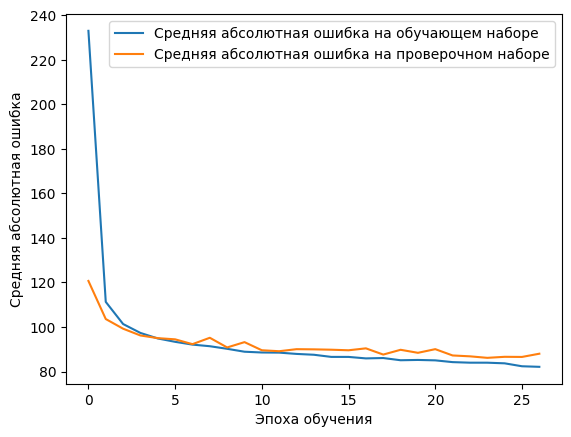

In [ ]:
model = Sequential()

model.add(Dense(32, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

history = model.fit(x_train,
                    y_train,
                    epochs=100,
                    batch_size=128,
                    validation_split=0.15,
                    verbose=1, 
                    callbacks=[earlystop, reduceLROnPlateau, model_Checkpoint])

plot_history(history)

439/439 [==============================] - 1s 2ms/step
Средняя абсолютная ошибка: 89.38245674562566 

Реальное значение: 449.00  Предсказанное значение: 417.52  Разница:  31.48
Реальное значение: 499.00  Предсказанное значение: 324.93  Разница: 174.07
Реальное значение: 200.00  Предсказанное значение: 416.36  Разница: 216.36
Реальное значение: 300.00  Предсказанное значение: 280.12  Разница:  19.88
Реальное значение: 525.00  Предсказанное значение: 438.93  Разница:  86.07
Реальное значение: 439.00  Предсказанное значение: 401.53  Разница:  37.47
Реальное значение: 265.00  Предсказанное значение: 233.10  Разница:  31.90
Реальное значение: 453.00  Предсказанное значение: 476.06  Разница:  23.06
Реальное значение: 710.00  Предсказанное значение: 563.17  Разница: 146.83
Реальное значение: 391.00  Предсказанное значение: 316.00  Разница:  75.00

Средняя цена машины = 527.72
Средняя ошибка = 89.38245674562566
Суммарный проент ошибки =  16.94 %


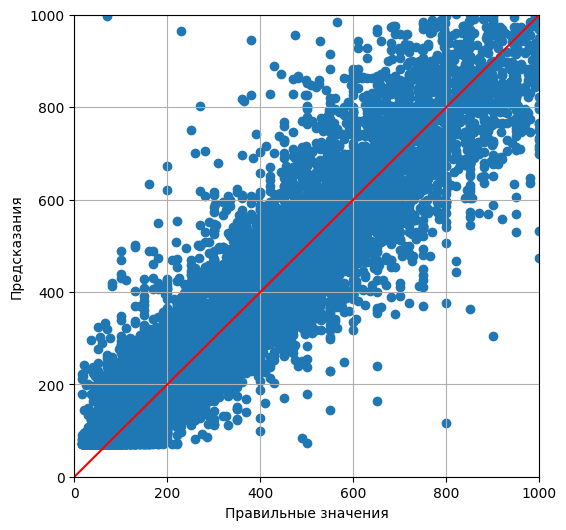

In [ ]:
eval_net(model, x_test, y_test)

# Модель №2 Sequential(), но с нормализованными метками

In [ ]:
from sklearn.preprocessing import StandardScaler

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.fit_transform(y_test)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 177)              708       
 ormalization)                                                   
                                                                 
 dense_4 (Dense)             (None, 64)                11392     
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 53,701
Trainable params: 53,347
Non-trainable params: 354
________________________________________________

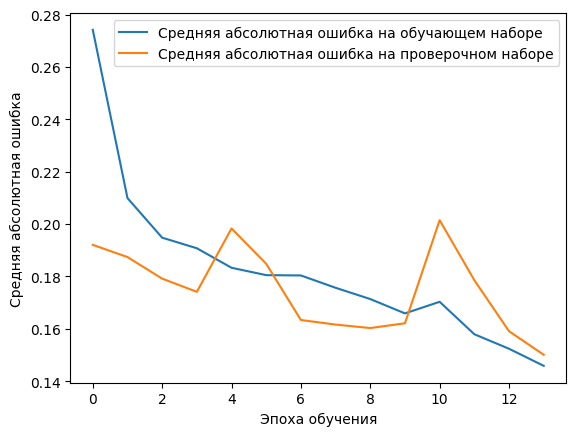

In [ ]:
model = Sequential()
model.add(BatchNormalization(input_dim=x_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='tanh'))
model.add(Dense(256, activation='tanh'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

history = model.fit(x_train,
          y_train_scaled,
          epochs=50,
          batch_size=100,
          validation_split=0.15,
          verbose=1, 
          callbacks=[earlystop, reduceLROnPlateau, model_Checkpoint])

plot_history(history)

439/439 [==============================] - 1s 2ms/step
Средняя абсолютная ошибка: 106.89130987910595 

Реальное значение: 449.00  Предсказанное значение: 431.98  Разница:  17.02
Реальное значение: 499.00  Предсказанное значение: 303.05  Разница: 195.95
Реальное значение: 200.00  Предсказанное значение: 282.31  Разница:  82.31
Реальное значение: 300.00  Предсказанное значение: 246.86  Разница:  53.14
Реальное значение: 525.00  Предсказанное значение: 481.24  Разница:  43.76
Реальное значение: 439.00  Предсказанное значение: 431.52  Разница:   7.48
Реальное значение: 265.00  Предсказанное значение: 239.96  Разница:  25.04
Реальное значение: 453.00  Предсказанное значение: 529.35  Разница:  76.35
Реальное значение: 710.00  Предсказанное значение: 473.01  Разница: 236.99
Реальное значение: 391.00  Предсказанное значение: 355.14  Разница:  35.86

Средняя цена машины = 527.72
Средняя ошибка = 106.89130987910595
Суммарный проент ошибки =  20.26 %


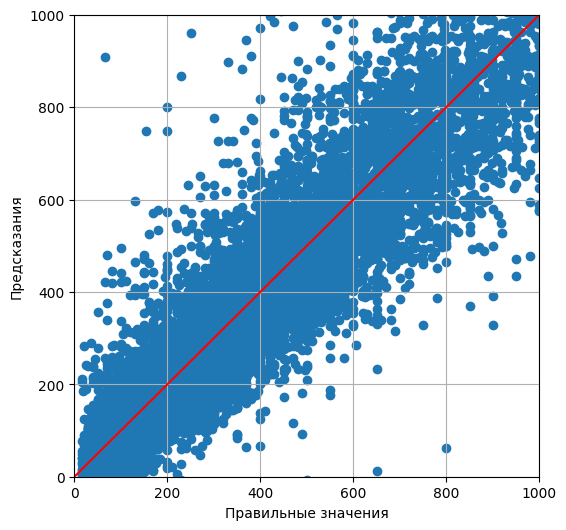

In [ ]:
eval_net(model, x_test, y_test, y_scaler)

# Модель №3 Model()

In [ ]:
"""
x_train, y_train
x_test, y_test

x_train_text, y_train_text
x_test_text, y_test_text
"""

'\nx_train, y_train\nx_test, y_test\n\nx_train_text, y_train_text\nx_test_text, y_test_text\n'

In [ ]:
x_train_text.shape

(70112, 10000)

In [ ]:
input1 = Input((x_train.shape[1],))
input2 = Input((x_train_text.shape[1],))

x1 = input1                               # Ветка 1
x1 = Dense(128, activation="relu")(x1)
x1 = Dropout(0.2)(x1)
x1 = Dense(1000, activation="tanh")(x1)
x1 = Dense(100, activation="relu")(x1)


x2 = input2                               # Ветка 2
x2 = Dense(1000, activation="relu")(x2)
x2 = Dropout(0.2)(x2)
x2 = Dense(100, activation="relu")(x2)


x = concatenate([x1, x2])             # Объединение трех веток

x = Dense(15, activation='relu')(x)       # Промежуточный слой
x = Dropout(0.5)(x)
x = Dense(1, activation='linear')(x)      # Финальный регрессирующий нейрон

# В Model передаются входы и выход
model_final = Model((input1, input2), x)

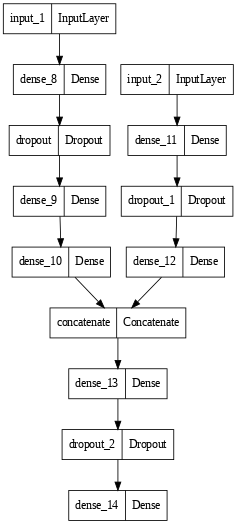

In [ ]:
utils.plot_model(model_final, dpi=60)

Epoch 1/50
185/187 [============================>.] - ETA: 0s - loss: 0.3949 - mae: 0.2970
Epoch 1: val_loss did not improve from 0.10347
187/187 [==============================] - 7s 21ms/step - loss: 0.3933 - mae: 0.2966 - val_loss: 0.1775 - val_mae: 0.1701 - lr: 0.0010
Epoch 2/50
186/187 [============================>.] - ETA: 0s - loss: 0.2802 - mae: 0.2501
Epoch 2: val_loss did not improve from 0.10347
187/187 [==============================] - 2s 13ms/step - loss: 0.2801 - mae: 0.2502 - val_loss: 0.1116 - val_mae: 0.1457 - lr: 0.0010
Epoch 3/50
186/187 [============================>.] - ETA: 0s - loss: 0.2465 - mae: 0.2358
Epoch 3: val_loss did not improve from 0.10347
187/187 [==============================] - 2s 13ms/step - loss: 0.2463 - mae: 0.2357 - val_loss: 0.1368 - val_mae: 0.1857 - lr: 0.0010
Epoch 4/50
187/187 [==============================] - ETA: 0s - loss: 0.2247 - mae: 0.2302
Epoch 4: val_loss improved from 0.10347 to 0.09384, saving model to /content/drive/My Driv

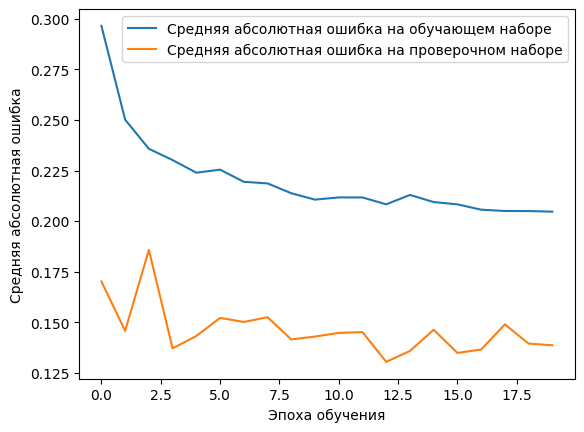

In [ ]:
model_final.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])

history = model_final.fit([x_train, x_train_text[:56089]],
                           y_train_scaled,
                           batch_size=256, 
                           epochs=50, 
                           validation_split=0.15,
                           verbose=1, 
                           callbacks=[earlystop, reduceLROnPlateau, model_Checkpoint])

plot_history(history)

1753/1753 [==============================] - 4s 2ms/step
Средняя абсолютная ошибка: 71.32295517209053 

Реальное значение: 996.00  Предсказанное значение: 1010.86  Разница:  14.86
Реальное значение: 140.20  Предсказанное значение: 209.57  Разница:  69.37
Реальное значение: 750.00  Предсказанное значение: 682.48  Разница:  67.52
Реальное значение: 970.00  Предсказанное значение: 914.51  Разница:  55.49
Реальное значение: 205.00  Предсказанное значение: 261.77  Разница:  56.77
Реальное значение: 985.00  Предсказанное значение: 1100.81  Разница: 115.81
Реальное значение: 589.00  Предсказанное значение: 587.76  Разница:   1.24
Реальное значение: 500.00  Предсказанное значение: 424.89  Разница:  75.11
Реальное значение: 1320.00  Предсказанное значение: 1000.07  Разница: 319.93
Реальное значение: 270.00  Предсказанное значение: 386.27  Разница: 116.27

Средняя цена машины = 527.72
Средняя ошибка = 71.32295517209053
Суммарный проент ошибки =  13.52 %


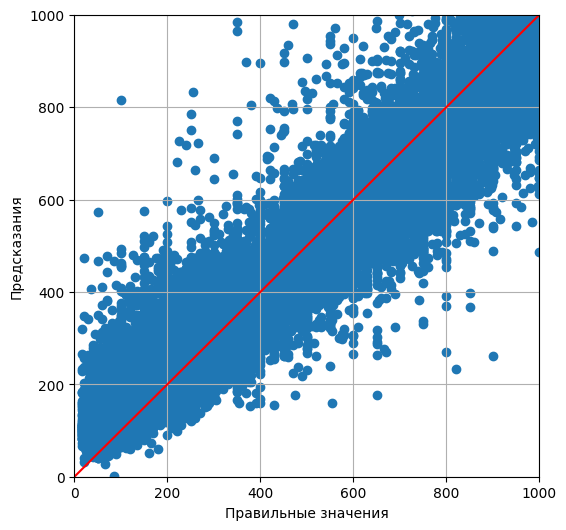

In [ ]:
eval_net(model_final, [x_train, x_train_text[:56089]], y_train, y_scaler)